In [1]:
import torch
import numpy as np
from torch import nn
import torchvision
from torchvision import transforms, datasets
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler

from matplotlib import pyplot as plt

import torch.nn.functional as F

from tqdm.notebook import tqdm

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

In [3]:
trainset= datasets.MNIST('~/.pytorch/MNIST/', train=True, download=True, transform=transform)

validset= datasets.MNIST('~/.pytorch/MNIST/', train=True, download=True, transform=transform)

testset= datasets.MNIST('~/.pytorch/MNIST/', train=False, download=True,transform=transform)

In [4]:
batch_size = 100
pin_memory = 1
num_workers = 1

In [5]:
# train_loader = torch.utils.data.DataLoader(
#     trainset, batch_size=batch_size,
#     num_workers=num_workers, pin_memory=pin_memory,
# )

In [6]:
num_train = len(trainset)
num_test = len(testset)
indices = list(range(num_train))
split = int(np.floor(0.3 * num_train))

np.random.seed(42)
np.random.shuffle(indices)

In [7]:
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, sampler=train_sampler,
    num_workers=num_workers, pin_memory=pin_memory,
)
valid_loader = torch.utils.data.DataLoader(
    validset, batch_size=batch_size, sampler=valid_sampler,
    num_workers=num_workers, pin_memory=pin_memory,
)

test_loader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, num_workers=num_workers, 
    pin_memory=pin_memory, shuffle=True
)

In [8]:
for imgs,labels in train_loader:
    print(imgs.shape,labels.shape)
    break

torch.Size([100, 1, 28, 28]) torch.Size([100])


In [9]:
class AutoEncoder(nn.Module):
    def __init__(self, hidden_channels=128):
        super().__init__()
        self.cnn1 = nn.Conv2d(1,32,kernel_size=3,padding=1)
        self.cnn2 = nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.cnn3 = nn.Conv2d(64,hidden_channels,kernel_size=7)

        self.pool = nn.MaxPool2d(2,return_indices=True)
        
        self.unpool = nn.MaxUnpool2d(2)
        
        self.t_cnn1 = nn.ConvTranspose2d(hidden_channels,64,kernel_size=7)
        self.t_cnn2 = nn.ConvTranspose2d(64,32,kernel_size=3,padding=1)
        self.t_cnn3 = nn.ConvTranspose2d(32,1,kernel_size=3,padding=1)
        
    def forward(self,x):
        out = F.relu(self.cnn1(x))
        out,ind1 = self.pool(out)
        
        out = F.relu(self.cnn2(out))
        out,ind2 = self.pool(out)

        out = self.cnn3(out)
        
        out = F.relu(self.t_cnn1(out))
        out = self.unpool(out,ind2)

        out = F.relu(self.t_cnn2(out))
        out = self.unpool(out,ind1)

        out = torch.sigmoid(self.t_cnn3(out))
        
        return out
        

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [28]:
def train(model, optimizer, scheduler, epochs,get_imgs=False):
    criterion = nn.MSELoss()
    inputs = list()
    outputs = list()
    losses = list()
    pbar = tqdm(total = epochs)
    pbar.set_postfix({'Loss': '-'})
    
    for e in range(epochs):
        iter_n = 0
        cumu_loss = 0
#         print("Epoch %d of %d"%(e+1,epochs))
        for imgs,_ in train_loader:

            imgs = imgs.to(device)
            optimizer.zero_grad()
            recons = model(imgs)
            
            if(iter_n==0 and get_imgs):
                inputs.append(imgs[0].cpu().data)
                outputs.append(recons[0].cpu().data)

            loss = criterion(recons,imgs)
            loss.backward()
            optimizer.step()
            
            iter_n += 1
            
            cumu_loss += loss.item()
        scheduler.step()
        curr_loss = cumu_loss*1.0/iter_n
        losses.append(curr_loss)
        pbar.update(1)
        pbar.set_postfix({'Loss': curr_loss})
    if get_imgs:
        return losses,(inputs,outputs)
    else:
        return losses, None

In [44]:
def test(model,get_imgs=False):
    criterion = nn.MSELoss()
    inputs = list()
    outputs = list()
    iter_n = 0
    cumu_loss = 0
#         print("Epoch %d of %d"%(e+1,epochs))
    for imgs,_ in train_loader:

        imgs = imgs.to(device)
        recons = model(imgs)

        if(iter_n==0 and get_imgs):
            inputs.append(imgs[0].cpu().data)
            outputs.append(recons[0].cpu().data)

        loss = criterion(recons,imgs)

        iter_n += 1

        cumu_loss += loss.item()
    losses = cumu_loss*1.0/iter_n
    if get_imgs:
        return losses,(inputs,outputs)
    else:
        return losses, None

In [66]:
loss_dict = {}

In [67]:
model = AutoEncoder(hidden_channels=10).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr= 0.0001,weight_decay=1e-5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25,30],gamma=0.1)
epochs = 35
losses,_ = train(model, optimizer, scheduler, epochs)
test_loss, _ = test(model)
loss_dict['Adam'] = test_loss
print('Train Loss: {}. Test Loss: {}'.format(losses[-1],test_loss))

Train Loss: 0.0024150196412977363. Test Loss: 0.0024134698717500126


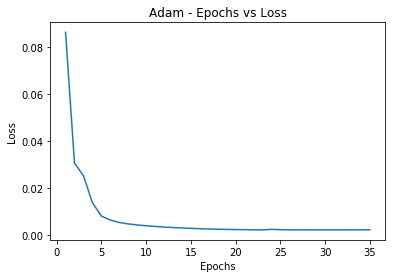

In [68]:
plt.plot(np.arange(1,epochs+1),losses)
plt.title('Adam - Epochs vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [69]:
model = AutoEncoder(hidden_channels=10).to(device)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(),lr= 0.0001,weight_decay=1e-5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25,30],gamma=0.1)
epochs = 35
losses,_ = train(model, optimizer, scheduler, epochs)
test_loss, _ = test(model)
loss_dict['RMSprop'] = test_loss
print('Train Loss: {}. Test Loss: {}'.format(losses[-1],test_loss))

Train Loss: 0.0017742446717983556. Test Loss: 0.0017741595472519597


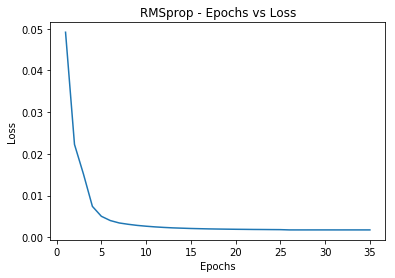

In [70]:
plt.plot(np.arange(1,epochs+1),losses)
plt.title('RMSprop - Epochs vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [71]:
model = AutoEncoder(hidden_channels=128).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(),lr= 0.5,momentum=0.7,weight_decay=1e-5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15],gamma=0.1)
epochs = 35
losses,_ = train(model, optimizer, scheduler, epochs)
test_loss, _ = test(model)
loss_dict['SGD w momentum'] = test_loss
print('Train Loss: {}. Test Loss: {}'.format(losses[-1],test_loss))

Train Loss: 0.0023318188658560672. Test Loss: 0.0023287761474161278


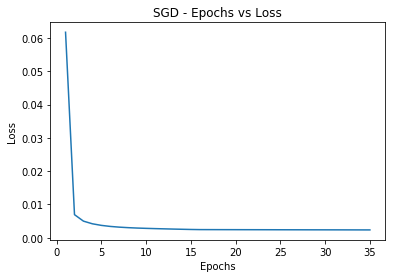

In [72]:
plt.plot(np.arange(1,epochs+1),losses)
plt.title('SGD - Epochs vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [73]:
model = AutoEncoder(hidden_channels=10).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(),lr= 0.8,weight_decay=1e-5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20],gamma=0.1)
epochs = 35
losses,_ = train(model, optimizer, scheduler, epochs)
test_loss, _ = test(model)
loss_dict['SGD w/o momentum'] = test_loss
print('Train Loss: {}. Test Loss: {}'.format(losses[-1],test_loss))

Train Loss: 0.0027568549050816468. Test Loss: 0.0027544945971818553


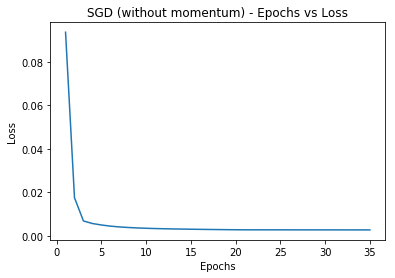

In [74]:
plt.plot(np.arange(1,epochs+1),losses)
plt.title('SGD (without momentum) - Epochs vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.bar()

In [75]:
losses_dict={}

In [77]:
hc_list = [10,32,64,128,256,512]
loss_list = list()
for hc in hc_list:
    model = AutoEncoder(hidden_channels=hc).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(),lr= 0.0001,weight_decay=1e-5)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25,30],gamma=0.1)
    epochs = 35
    _,_ = train(model, optimizer, scheduler, epochs)
    test_loss, _ = test(model)
    loss_list.append(test_loss)
    print("Hidden Neurons: {}, Loss: {}".format(hc,test_loss))
losses_dict['Adam'] = loss_list

Hidden Neurons: 10, Loss: 0.0020873267974127973


Hidden Neurons: 32, Loss: 0.0012911743470578499


Hidden Neurons: 64, Loss: 0.0015537289084888817



Hidden Neurons: 128, Loss: 0.0013829733308825998



Hidden Neurons: 256, Loss: 0.0010521506401433033


Hidden Neurons: 512, Loss: 0.0016476421921868764


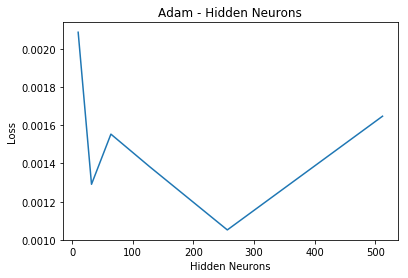

In [80]:
plt.plot(hc_list,losses_dict['Adam'])
plt.title('Adam - Hidden Neurons')
plt.xlabel('Hidden Neurons')
plt.ylabel('Loss')
plt.show()

In [81]:
hc_list = [10,32,64,128,256,512]
loss_list = list()
for hc in hc_list:
    model = AutoEncoder(hidden_channels=hc).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.RMSprop(model.parameters(),lr= 0.0001,weight_decay=1e-5)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25,30],gamma=0.1)
    epochs = 35
    _,_ = train(model, optimizer, scheduler, epochs)
    test_loss, _ = test(model)
    loss_list.append(test_loss)
    print("Hidden Neurons: {}, Loss: {}".format(hc,test_loss))
losses_dict['RMSprop'] = loss_list

Hidden Neurons: 10, Loss: 0.001808540846797682


Hidden Neurons: 32, Loss: 0.0013766202648791174


Hidden Neurons: 64, Loss: 0.0010244752302588451



Hidden Neurons: 128, Loss: 0.0010865111576138242



Hidden Neurons: 256, Loss: 0.0011108719882377911


Hidden Neurons: 512, Loss: 0.0011575526280683422


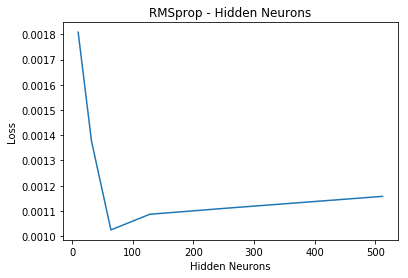

In [82]:
plt.plot(hc_list,losses_dict['RMSprop'])
plt.title('RMSprop - Hidden Neurons')
plt.xlabel('Hidden Neurons')
plt.ylabel('Loss')
plt.show()

In [112]:
hc_list = [10,32,64,128,256,512]
loss_list = list()
for hc in hc_list:
    model = AutoEncoder(hidden_channels=hc).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(),lr= 0.5,momentum=0.7,weight_decay=1e-5)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15],gamma=0.1)
    epochs = 35
    _,_ = train(model, optimizer, scheduler, epochs)
    test_loss, _ = test(model)
    loss_list.append(test_loss)
    print("Hidden Neurons: {}, Loss: {}".format(hc,test_loss))
losses_dict['SGD w momentum'] = loss_list

Hidden Neurons: 10, Loss: 0.002286257809360645


Hidden Neurons: 32, Loss: 0.0024263658034171733


Hidden Neurons: 64, Loss: 0.002514504843081037


Hidden Neurons: 128, Loss: 0.002033469595924197



Hidden Neurons: 256, Loss: 0.0022161346095214995



Hidden Neurons: 512, Loss: 0.001998218500687342


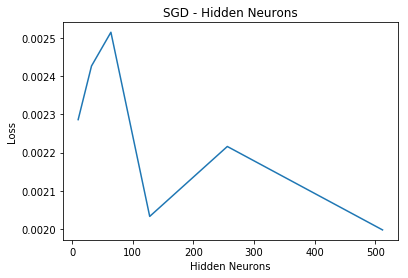

In [113]:
plt.plot(hc_list,losses_dict['SGD w momentum'])
plt.title('SGD - Hidden Neurons')
plt.xlabel('Hidden Neurons')
plt.ylabel('Loss')
plt.show()

In [114]:
hc_list = [10,32,64,128,256,512]
loss_list = list()
for hc in hc_list:
    model = AutoEncoder(hidden_channels=hc).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(),lr= 0.8,weight_decay=1e-5)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20],gamma=0.1)
    epochs = 35
    _,_ = train(model, optimizer, scheduler, epochs)
    test_loss, _ = test(model)
    loss_list.append(test_loss)
    print("Hidden Neurons: {}, Loss: {}".format(hc,test_loss))
losses_dict['SGD w/o momentum'] = loss_list

Hidden Neurons: 10, Loss: 0.002776450494725612


Hidden Neurons: 32, Loss: 0.002883089225118359


Hidden Neurons: 64, Loss: 0.0027714018393973153



Hidden Neurons: 128, Loss: 0.0025177748264035298



Hidden Neurons: 256, Loss: 0.002450077261753558


Hidden Neurons: 512, Loss: 0.0023405866093179654


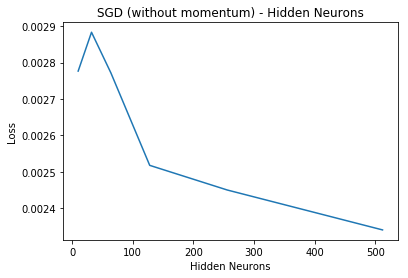

In [115]:
plt.plot(hc_list,losses_dict['SGD w/o momentum'])
plt.title('SGD (without momentum) - Hidden Neurons')
plt.xlabel('Hidden Neurons')
plt.ylabel('Loss')
plt.show()

In [91]:
train_X = trainset.data.numpy()[train_idx]
valid_X = trainset.data.numpy()[valid_idx]

train_X = train_X.reshape(train_X.shape[0],-1)
valid_X = valid_X.reshape(valid_X.shape[0],-1)

In [93]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [104]:
dims = [10,32,64,128,256,512]
for dim in dims:
    pca = PCA(dim)
    pca.fit(train_X)
    TRAIN = pca.transform(train_X)
    VALID = pca.transform(valid_X)
    train_recons = pca.inverse_transform(TRAIN)
    valid_recons = pca.inverse_transform(VALID)


    train_error = mean_squared_error(train_X,train_recons)/train_X.shape[0]

    valid_error = mean_squared_error(valid_X,valid_recons)/valid_X.shape[0]

    print('Dimensions: {}. Train Loss: {}. Test Loss: {}'.format(dim,train_error,valid_error))

Dimensions: 10. Train Loss: 0.053271846154111235. Test Loss: 0.12450912399891462
Dimensions: 32. Train Loss: 0.026678029403940866. Test Loss: 0.06246120283687559
Dimensions: 64. Train Loss: 0.014355064819090222. Test Loss: 0.03373332851131508
Dimensions: 128. Train Loss: 0.006635275848144878. Test Loss: 0.01563624912222272
Dimensions: 256. Train Loss: 0.0021801371737560716. Test Loss: 0.005197391148394002
Dimensions: 512. Train Loss: 5.986472794219938e-05. Test Loss: 0.00015147129286793314


## Best Model

In [106]:
model = AutoEncoder(hidden_channels=64).to(device)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(),lr= 0.0001,weight_decay=1e-5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25,30],gamma=0.1)
epochs = 35
train_losses, img_ops = train(model, optimizer, scheduler, epochs,get_imgs=True)
test_loss, _ = test(model)

In [116]:
print('Train Loss: {}. Test Loss: {}'.format(train_losses[-1],test_loss))

Train Loss: 0.0012427493713663093. Test Loss: 0.0023405866093179654


Epoch 1


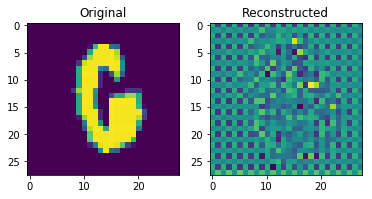

Epoch 2


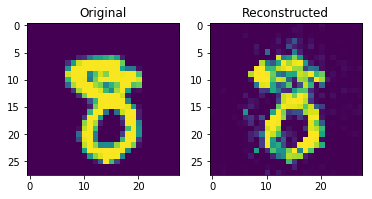

Epoch 3


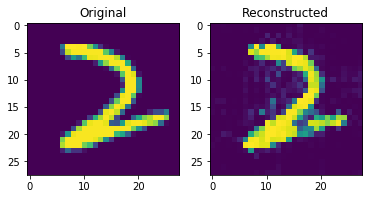

Epoch 4


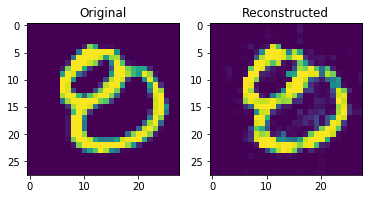

Epoch 5


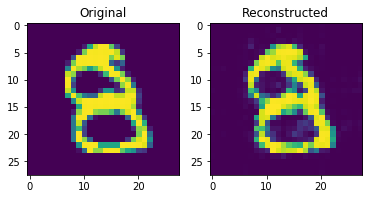

Epoch 6


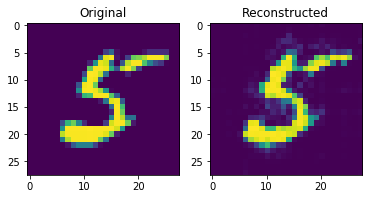

Epoch 7


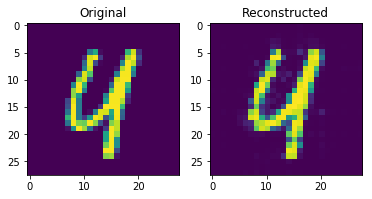

Epoch 8


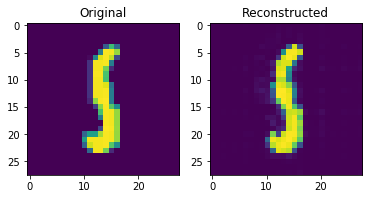

Epoch 9


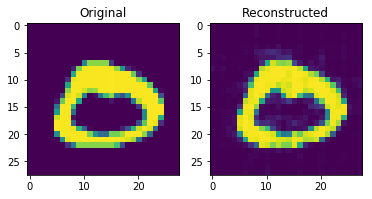

Epoch 10


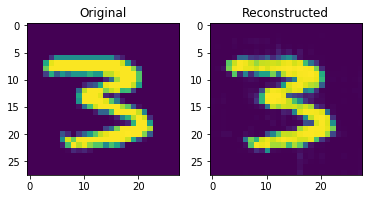

Epoch 11


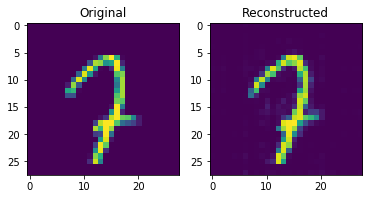

Epoch 12


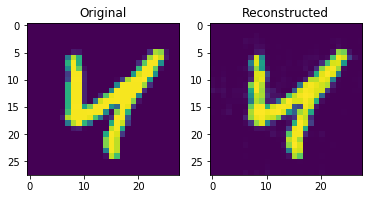

Epoch 13


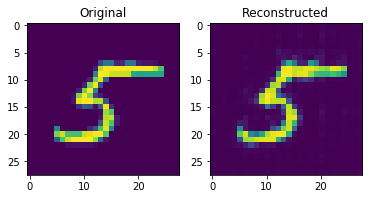

Epoch 14


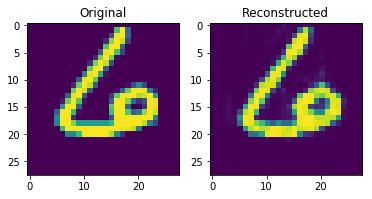

Epoch 15


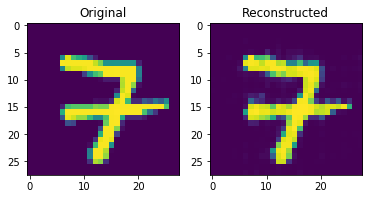

Epoch 16


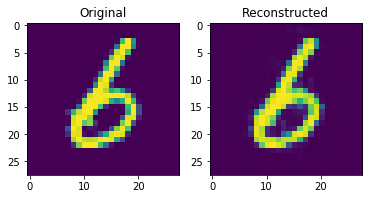

Epoch 17


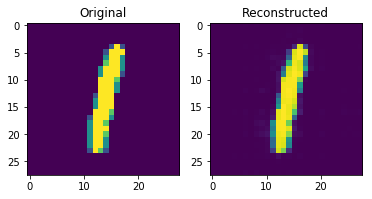

Epoch 18


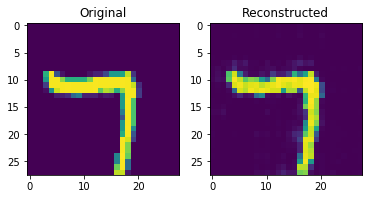

Traceback (most recent call last):
  File "/usr/local/apps/python-3.7.4/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/local/apps/python-3.7.4/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/local/apps/python-3.7.4/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/local/apps/python-3.7.4/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Exception ignored in: <function _ConnectionBase.__del__ at 0x14d3dffecd40>
Traceback (most recent call last):
  File "/usr/local/apps/python-3.7.4/lib/python3.7/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/usr/local/apps/python-3.7.4/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad




Epoch 19


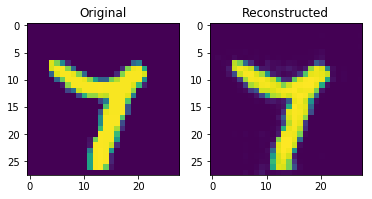

Epoch 20


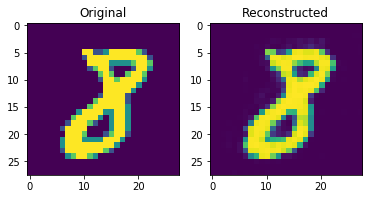

Epoch 21


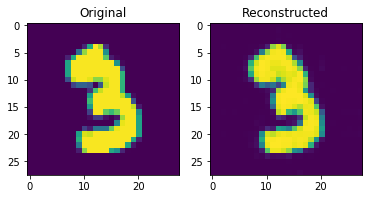

Epoch 22


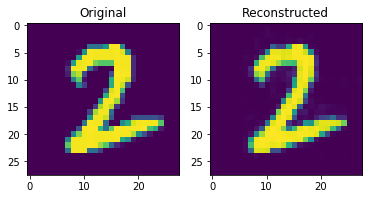

Epoch 23


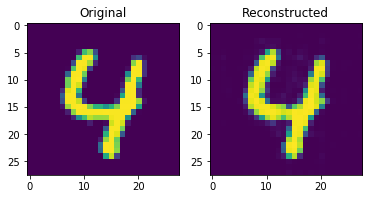

Epoch 24


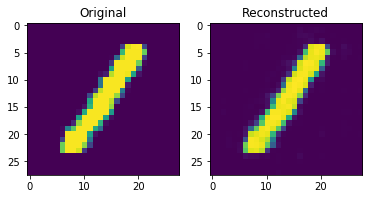

Epoch 25


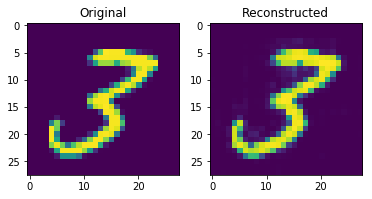

Epoch 26


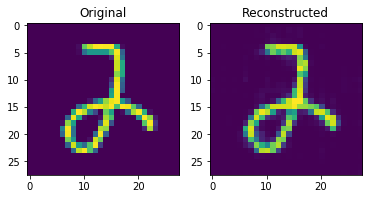

Epoch 27


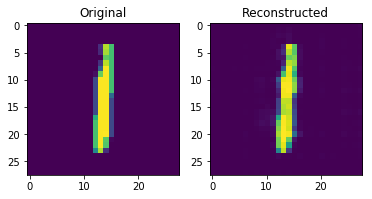

Epoch 28


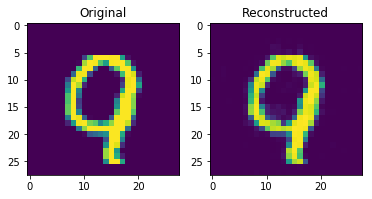

Epoch 29


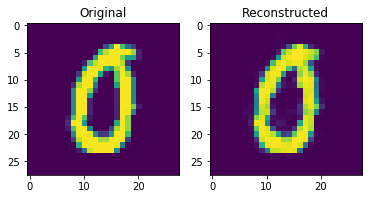

Epoch 30


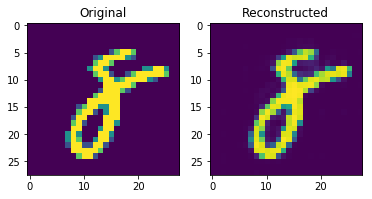

Epoch 31


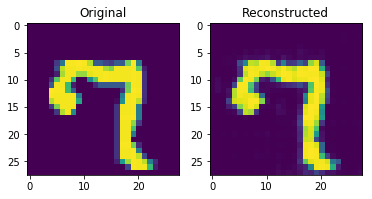

Epoch 32


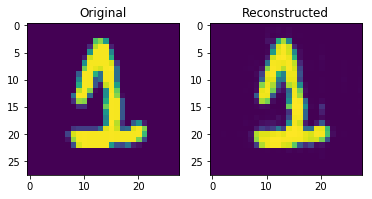

Epoch 33


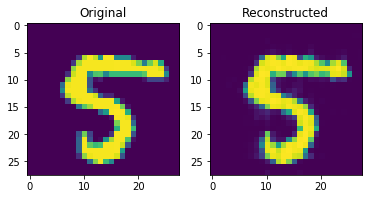

Epoch 34


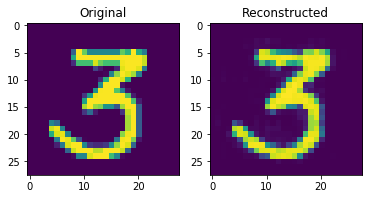

Epoch 35


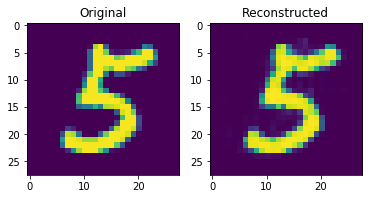

In [110]:
for e in range(len(img_ops[0])):
    fig,ax = plt.subplots(1,2)
    print("Epoch {}".format(e+1))
    ax[0].imshow(img_ops[0][e].numpy()[0])
    ax[0].title.set_text('Original')
    ax[1].imshow(img_ops[1][e].numpy()[0])
    ax[1].title.set_text('Reconstructed')
    
    plt.show()

In [111]:
torch.save(model.state_dict(), 'q2.pth')

In [118]:
torch.save(model, 'full_q2.pth')